In [1]:
import torch
from txai.models.encoders.transformer_simple import TransformerMVTS
from txai.utils.predictors.eval import eval_mv4
from txai.synth_data.simple_spike import SpikeTrainDataset
from txai.utils.data import process_Synth

In [2]:
D = process_Synth(split_no = 1, device = None, base_path = '/n/data1/hms/dbmi/zitnik/lab/users/owq978/TimeSeriesCBM/datasets/FreqShapeUD')

model = TransformerMVTS(
    d_inp = 1,
    max_len = 50,
    n_classes = 4,
    trans_dim_feedforward = 16,
    trans_dropout = 0.1,
    d_pe = 16,
    # aggreg = 'mean',
    # norm_embedding = True
)

model.load_state_dict(torch.load('models/transformer_split=1_cpu.pt'))

<All keys matched successfully>

In [3]:
X, times, y = D['test']

In [4]:
from txai.utils.predictors import eval_mvts_transformer

out = model.embed(X, times, captum_input = False)

In [5]:
# Model performance:
f1 = eval_mvts_transformer(D['test'], model)
print(f1)

0.984964855165183


In [6]:
gt_exp = D['gt_exps'].float()
print(gt_exp.shape)

torch.Size([50, 1000, 1])


In [7]:
from txai.utils.functional import transform_to_attn_mask

attn_masks = transform_to_attn_mask(gt_exp.squeeze(-1).transpose(0,1))
print(attn_masks.shape)

torch.Size([1000, 50, 50])


In [8]:
model.eval()
with torch.no_grad():
    out_masked = model.embed(X, times, captum_input = False, attn_mask = attn_masks)
print(out_masked.shape)

torch.Size([1000, 17])


In [9]:
import torch.nn.functional as F

sim = F.cosine_similarity(out, out_masked)
print(sim.mean().item())

0.8028206825256348


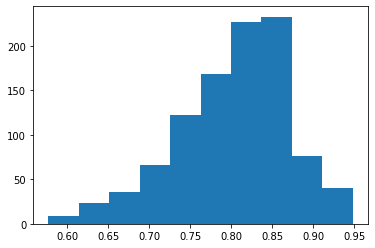

In [10]:
import matplotlib.pyplot as plt

plt.hist(sim.detach().numpy())
plt.show()

In [11]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

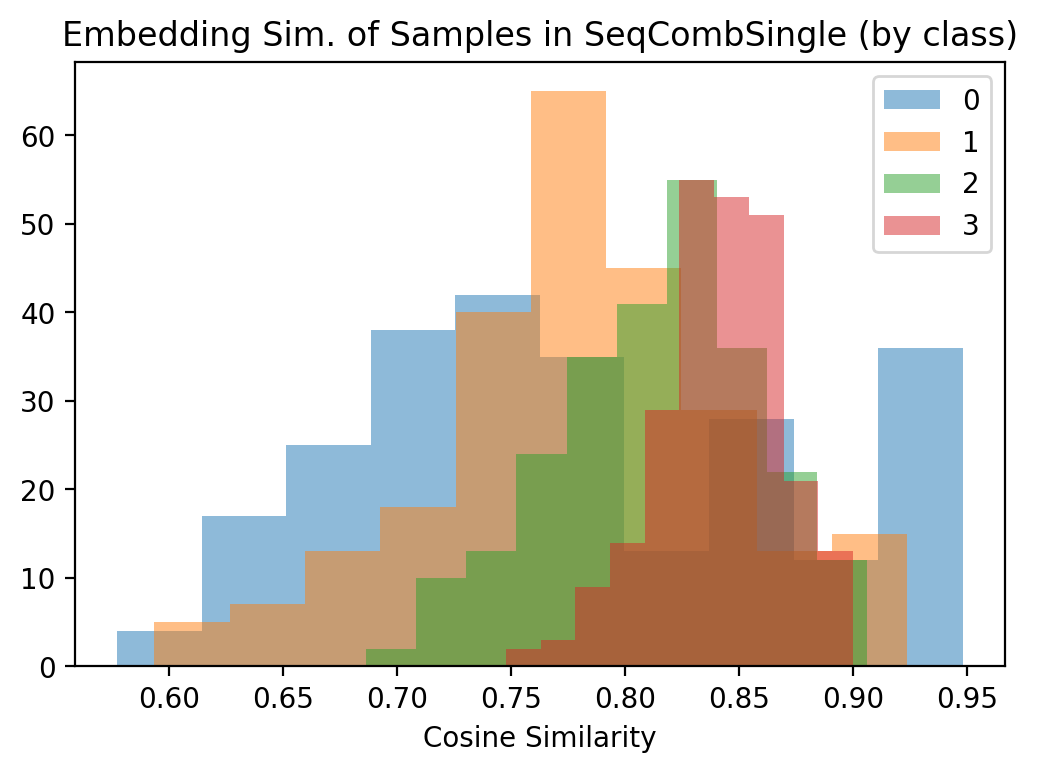

In [12]:
sim_np = sim.detach().numpy()
ynp = y.detach().numpy()
for yi in y.unique().detach().numpy():
    plt.hist(sim_np[ynp == yi], alpha = 0.5, label = '{}'.format(yi))
plt.legend()
plt.title('Embedding Sim. of Samples in SeqCombSingle (by class)')
plt.xlabel('Cosine Similarity')
plt.show()

In [18]:
# Run a test - are embeddings of ground-truth masks of samples closer than some other samples?
# Create sim. matrix, ordered by classes:
import torch.nn.functional as F
out_norm = F.normalize(out, dim = -1)
out_masked_norm = F.normalize(out_masked, dim = -1)

#outer = torch.bmm(out_norm.unsqueeze(-1), out_masked_norm.unsqueeze(1))
from tqdm import trange
import numpy as np
sim_mat = np.zeros((1000, 1000))
for i in trange(out_norm.shape[0]):
    for j in range(out_masked_norm.shape[0]):
        sim_mat[i,j] = torch.dot(out_norm[i,:], out_masked_norm[j,:])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.17it/s]


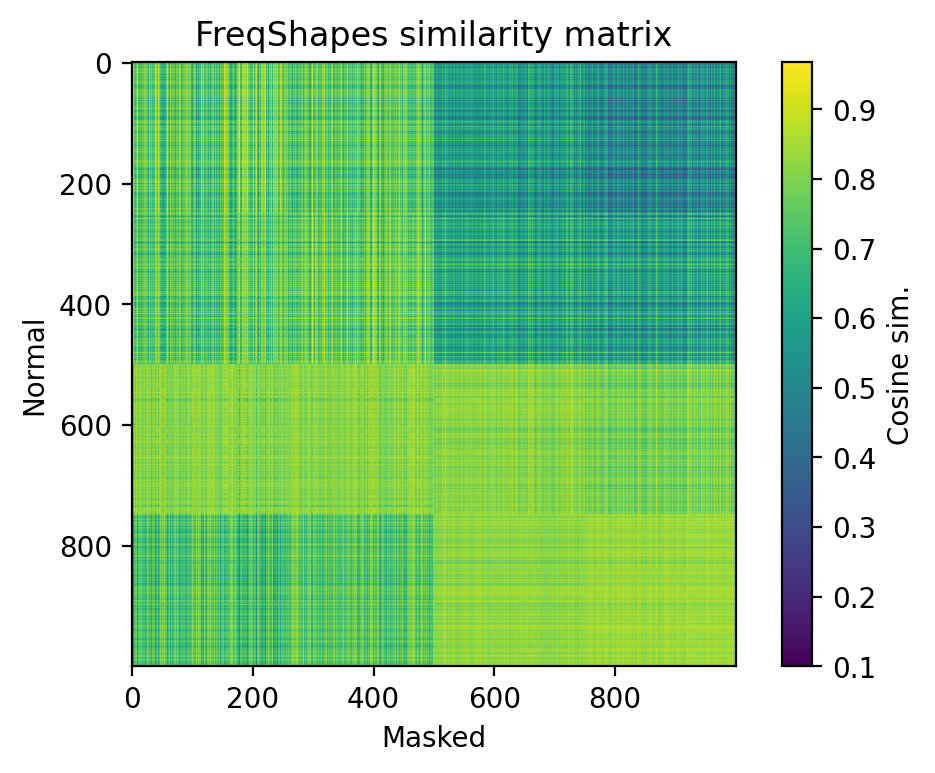

In [19]:
plt.imshow(sim_mat)
cbar = plt.colorbar()
cbar.set_label('Cosine sim.')
plt.ylabel('Normal')
plt.xlabel('Masked')
plt.title('FreqShapes similarity matrix')
plt.show()

In [14]:
# Get predictions of each:
model.eval()
with torch.no_grad():
    pred = model(X, times)
    pred_masked = model(X, times, attn_mask = attn_masks)

In [15]:
from sklearn.metrics import f1_score

pred_masked_np = pred_masked.argmax(dim=-1).detach().numpy()

f1 = f1_score(y[y != 0], pred_masked_np[y!=0], average = 'macro')
print('f1 w/o class 0: {:.4f}'.format(f1))

for yi in y.unique().detach().numpy():
    acc = (pred_masked_np[ynp == yi] == yi).sum() / (ynp == yi).sum()
    print('Acc. {} = {:.4f}'.format(yi, acc))

f1 w/o class 0: 0.4591
Acc. 0 = 0.2840
Acc. 1 = 0.5520
Acc. 2 = 0.0360
Acc. 3 = 1.0000


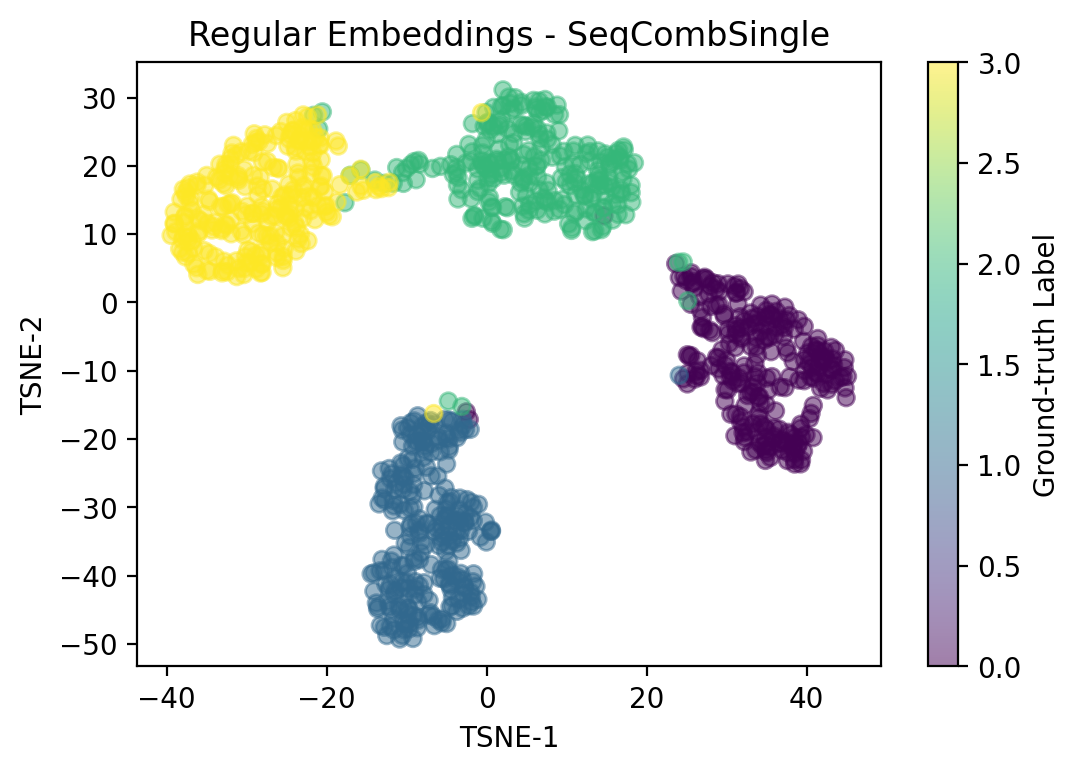

In [16]:
from sklearn.manifold import TSNE

out_tsne = TSNE().fit_transform(out.detach().numpy())
plt.scatter(out_tsne[:,0], out_tsne[:,1], c = ynp, alpha = 0.5)
plt.title('Regular Embeddings - SeqCombSingle')
cbar = plt.colorbar()
cbar.set_label('Ground-truth Label')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()

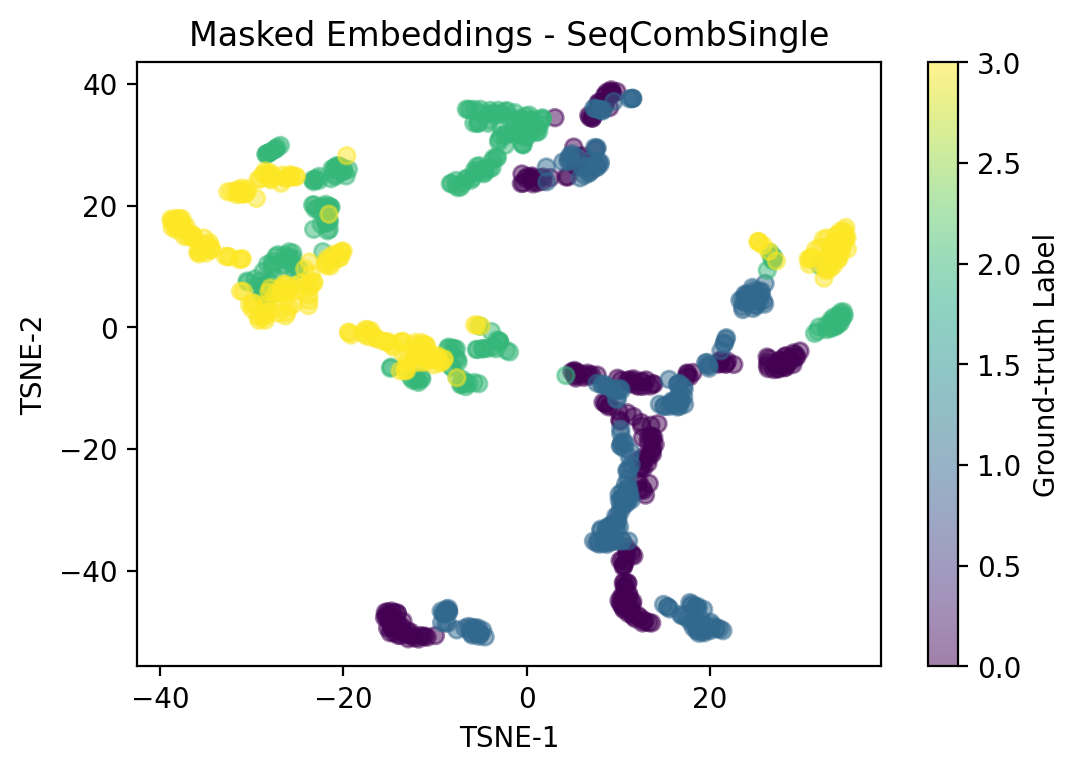

In [17]:
out_mask_tsne = TSNE().fit_transform(out_masked.detach().numpy())
plt.scatter(out_mask_tsne[:,0], out_mask_tsne[:,1], c = ynp, alpha = 0.5)
plt.title('Masked Embeddings - SeqCombSingle')
cbar = plt.colorbar()
cbar.set_label('Ground-truth Label')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()